<a href="https://www.kaggle.com/code/amaninaman/nyc-taxi-trip-records-with-gas-prices?scriptVersionId=155757818" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# MERGING NYC GAS PRICE DATA WITH NYC TAXI TRIP RECORDS DATA SET
In this notebook, I augment the analysis of NYC taxi trip records (Jan-Aug 2023) by integrating external data on weekly average motor gasoline prices from NYSERDA. After loading and exploring the main dataset, I scrape and process gas prices. The notebook then aligns trip data with gas prices based on pickup dates, addressing missing values through a fill strategy. Duplicate rows are removed, and a 'Gas Prices' column is added, representing gasoline prices in cents per gallon for each trip. The goal is to uncover correlations between taxi fares and gasoline prices, shedding light on potential patterns amid fuel cost fluctuations. Motivated by my observation that Uber prices were more affordable in Boston compared to Seattle, with a parallel difference in gas prices, I recognized the significance of considering fuel costs in such analyses. 


![](https://i.postimg.cc/Kcgh5DKp/column.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/kaggle/input/nyc-taxi-trip-records-from-jan-2023-to-jun-2023/nyc_yellow_taxi_trip_records_from_Jan_to_Aug_2023.csv')
df.head(35)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
0,0,2,2023-06-30 23:59:59,2023-07-01 00:47:49,2.0,17.62,2.0,N,132,230,...,70.00,0.0,0.5,0.00,6.55,1.0,82.30,2.5,1.75,NaN
1,1,2,2023-06-30 23:59:57,2023-07-01 00:17:36,1.0,3.32,1.0,N,255,198,...,18.40,1.0,0.5,2.50,0.00,1.0,23.40,0.0,0.00,NaN
2,2,1,2023-06-30 23:59:55,2023-07-01 00:14:20,1.0,2.80,1.0,N,231,107,...,14.90,3.5,0.5,3.95,0.00,1.0,23.85,2.5,0.00,NaN
3,3,2,2023-06-30 23:59:55,2023-07-01 00:05:52,1.0,0.89,1.0,N,237,163,...,7.20,1.0,0.5,2.00,0.00,1.0,14.20,2.5,0.00,NaN
4,4,2,2023-06-30 23:59:55,2023-07-01 00:07:08,4.0,1.56,1.0,N,211,90,...,10.00,1.0,0.5,3.00,0.00,1.0,18.00,2.5,0.00,NaN
5,5,2,2023-06-30 23:59:54,2023-07-01 00:14:58,1.0,3.85,1.0,N,161,166,...,19.10,1.0,0.5,10.00,0.00,1.0,34.10,2.5,0.00,NaN
6,6,2,2023-06-30 23:59:53,2023-07-01 00:05:52,2.0,1.05,1.0,N,65,33,...,7.90,1.0,0.5,2.08,0.00,1.0,12.48,0.0,0.00,NaN
7,7,2,2023-06-30 23:59:53,2023-07-01 00:08:36,1.0,1.50,1.0,N,107,249,...,10.70,1.0,0.5,3.14,0.00,1.0,18.84,2.5,0.00,NaN
8,8,1,2023-06-30 23:59:52,2023-07-01 00:15:15,3.0,2.80,1.0,N,48,79,...,14.90,3.5,0.5,4.00,0.00,1.0,23.90,2.5,0.00,NaN
9,9,2,2023-06-30 23:59:51,2023-07-01 00:08:49,1.0,2.17,1.0,N,90,48,...,12.10,1.0,0.5,0.00,0.00,1.0,17.10,2.5,0.00,NaN


Since it is going to take a lot of time to iterate 19,493,059 records, We will use random.sample() function to generate 1,000,000 unique index numbers to randomly select one million records from the dataframe. **If you are sure that your system can handle huge amount data you can skip the next three code blocks.**

In [3]:
import random
random.seed(84)
index_list=random.sample(range(0, df.shape[0]), 1000000)
print(index_list[0:100])

[9515636, 1252585, 16412614, 147355, 17505513, 10687702, 6597892, 15445528, 16734413, 18503378, 12306519, 5042518, 18283885, 8768609, 17637043, 15682645, 13374855, 11079676, 7364167, 4219952, 15884668, 1470038, 17204457, 1478869, 5012808, 1564153, 16766872, 17733814, 9787237, 17976585, 3612909, 395362, 8102923, 6792100, 14176160, 4553382, 9816589, 3777261, 9116182, 4060828, 3431414, 18258850, 2458429, 15612366, 18514929, 986802, 4911357, 16139179, 838238, 4551530, 18407449, 6375432, 5276802, 8865336, 6220089, 10692006, 12351950, 18046338, 10347972, 5062845, 16397512, 14183468, 5789165, 18735488, 561802, 2611254, 434376, 15956721, 7427044, 8572921, 2913242, 4852992, 14626736, 17689895, 12918359, 13098449, 9057800, 11883078, 11746168, 9086932, 3449929, 178977, 9576991, 11808180, 18587526, 10347858, 2364866, 19057517, 7418235, 12632208, 19208204, 9046447, 11006685, 8842317, 17187484, 8721842, 16750075, 77964, 13539698, 357658]


In [4]:
index_list=np.array(index_list)
print(index_list.shape)
index_list=np.sort(index_list)
index_list[0:100]

(1000000,)


array([  14,   20,   23,   49,   57,   58,  102,  121,  130,  151,  171,
        180,  197,  199,  207,  223,  231,  242,  264,  271,  316,  330,
        385,  403,  425,  437,  446,  454,  456,  462,  481,  495,  499,
        504,  524,  537,  557,  564,  572,  596,  622,  627,  629,  635,
        644,  654,  687,  694,  732,  739,  755,  773,  779,  830,  857,
        871,  914,  915,  923,  980, 1002, 1005, 1034, 1052, 1057, 1069,
       1156, 1191, 1208, 1238, 1267, 1325, 1342, 1349, 1386, 1400, 1430,
       1453, 1498, 1527, 1551, 1563, 1619, 1620, 1633, 1663, 1671, 1679,
       1688, 1698, 1702, 1815, 1818, 1820, 1854, 1880, 1900, 1913, 1932,
       1941])

In [5]:
df=df.iloc[index_list].sort_index()
df.reset_index(inplace=True,drop=True)
df.head(35)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
0,14,1,2023-06-30 23:59:49,2023-07-01 00:06:23,2.0,0.90,1.0,N,209,232,...,7.20,3.50,0.5,0.00,0.00,1.0,12.20,2.5,0.00,NaN
1,20,2,2023-06-30 23:59:39,2023-07-01 00:27:22,1.0,6.82,1.0,N,68,74,...,32.40,1.00,0.5,11.22,0.00,1.0,48.62,2.5,0.00,NaN
2,23,2,2023-06-30 23:59:35,2023-07-01 00:17:16,1.0,2.26,1.0,N,186,141,...,17.00,1.00,0.5,4.40,0.00,1.0,26.40,2.5,0.00,NaN
3,49,1,2023-06-30 23:59:12,2023-07-01 00:50:07,1.0,16.50,2.0,N,132,164,...,70.00,4.25,0.5,16.45,6.55,1.0,98.75,2.5,1.75,NaN
4,57,2,2023-06-30 23:59:03,2023-07-01 00:54:01,3.0,17.55,2.0,N,132,48,...,70.00,0.00,0.5,20.14,6.55,1.0,100.69,2.5,0.00,NaN
5,58,2,2023-06-30 23:59:03,2023-07-01 00:10:35,4.0,2.73,1.0,N,249,229,...,14.20,1.00,0.5,2.00,0.00,1.0,21.20,2.5,0.00,NaN
6,102,1,2023-06-30 23:58:28,2023-07-01 00:27:34,1.0,12.80,1.0,N,163,250,...,50.60,3.50,0.5,13.90,0.00,1.0,69.50,2.5,0.00,NaN
7,121,2,2023-06-30 23:58:15,2023-07-01 00:11:35,1.0,2.53,1.0,N,148,90,...,14.90,1.00,0.5,2.00,0.00,1.0,21.90,2.5,0.00,NaN
8,130,1,2023-06-30 23:57:59,2023-06-30 23:58:07,2.0,0.70,1.0,N,249,249,...,3.00,3.50,0.5,0.00,0.00,1.0,8.00,2.5,0.00,NaN
9,151,2,2023-06-30 23:57:31,2023-07-01 00:02:13,1.0,1.41,1.0,N,249,186,...,7.90,1.00,0.5,2.58,0.00,1.0,15.48,2.5,0.00,NaN


The range of dates we will deal with:

In [6]:
print(df["tpep_pickup_datetime"].max())
print(df["tpep_pickup_datetime"].min())

2023-06-30 23:59:49
2023-01-01 00:00:52


*to_datetime()* function in Pandas will convert string values in pickup and dropoff columns into datetime64 datatype.

In [7]:
df["tpep_pickup_datetime"]=pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"]=pd.to_datetime(df["tpep_dropoff_datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1000000 non-null  int64         
 1   VendorID               1000000 non-null  int64         
 2   tpep_pickup_datetime   1000000 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  1000000 non-null  datetime64[ns]
 4   passenger_count        972851 non-null   float64       
 5   trip_distance          1000000 non-null  float64       
 6   RatecodeID             972851 non-null   float64       
 7   store_and_fwd_flag     972851 non-null   object        
 8   PULocationID           1000000 non-null  int64         
 9   DOLocationID           1000000 non-null  int64         
 10  payment_type           1000000 non-null  int64         
 11  fare_amount            1000000 non-null  float64       
 12  extra                  100000

In this step,we will get the data from the New York State Energy Research and Development Authority (NYSERDA) website, specifically the page detailing weekly average motor gasoline prices. It uses the *requests* library to retrieve the HTML content from the specified URL. The *pd.read_html()* function from the pandas library is then employed to extract tables from the HTML content, and the resulting data is actually a set of dataframes stored in the gas_prices variable.



In [8]:
import requests

url = requests.get('https://www.nyserda.ny.gov/Energy-Prices/Motor-Gasoline/Weekly-Average-Motor-Gasoline-Prices')
gas_prices=pd.read_html(url.text)

gas_prices


[                            Region  Price (cents per gallon):
 0               New York Statewide                      332.3
 1                 Upstate New York                      347.3
 2               Downstate New York                      317.9
 3  New York City Metropolitan Area                      321.0,
     Current Year                                           Last Year          
            Date: Price (cents per gallon): Price (cents per gallon): % Change:
 0     12/11/2023                     332.3                     344.1      -3.4
 1     12/04/2023                     336.6                     358.6      -6.1
 2     11/27/2023                     341.1                     366.3      -6.9
 3     11/20/2023                     342.8                     373.5      -8.2
 4     11/13/2023                     348.1                     380.8      -8.6
 ..           ...                       ...                       ...       ...
 96    01/31/2022                     347.0 

In [9]:
NY_gas_prices=gas_prices[1]

In [10]:
NY_gas_prices.iloc[:,0]

0      12/11/2023
1      12/04/2023
2      11/27/2023
3      11/20/2023
4      11/13/2023
          ...    
96     01/31/2022
97     01/24/2022
98     01/17/2022
99     01/10/2022
100    01/03/2022
Name: (Current Year, Date:), Length: 101, dtype: object

In [11]:
NY_gas_prices.iloc[:,1]

0      332.3
1      336.6
2      341.1
3      342.8
4      348.1
       ...  
96     347.0
97     341.6
98     339.3
99     339.8
100    341.9
Name: (Current Year, Price (cents per gallon):), Length: 101, dtype: float64

We will need first and second columns containing Date and Price(Current year) data.

In [12]:
NY_Dates_GasPrices=pd.concat([pd.to_datetime(NY_gas_prices.iloc[:,0]),NY_gas_prices.iloc[:,1]],axis="columns")
NY_Dates_GasPrices

Current Year                          
           Date: Price (cents per gallon):
0     2023-12-11                     332.3
1     2023-12-04                     336.6
2     2023-11-27                     341.1
3     2023-11-20                     342.8
4     2023-11-13                     348.1
..           ...                       ...
96    2022-01-31                     347.0
97    2022-01-24                     341.6
98    2022-01-17                     339.3
99    2022-01-10                     339.8
100   2022-01-03                     341.9

[101 rows x 2 columns]

2023-06-30 23:59:49 -
2023-01-01 00:00:52

These were the minimum and maximum values for the date column. To prepare this dataframe for matching the data on datetime values, we will filter the data to this range.

In [13]:
NY_Dates_GasPrices.columns=["Date","Price"]
NY_Dates_GasPrices=NY_Dates_GasPrices[(NY_Dates_GasPrices['Date']>='2023-01-01') & (NY_Dates_GasPrices['Date']<='2023-07-01')]
NY_Dates_GasPrices

,Date,Price
24,2023-06-26,359.2
25,2023-06-19,349.0
26,2023-06-12,358.2
27,2023-06-05,359.2
28,2023-05-29,359.7
29,2023-05-22,356.0
30,2023-05-15,356.6
31,2023-05-08,358.0
32,2023-05-01,362.7
33,2023-04-24,361.2


As it was stated, NY gas prices are showing the weekly average instead of daily prices.This code is calculating the number of days to be created first and then generating a numpy list called *date_list* by adding consecutive amount of days to the minimum date value. The idea is to create a seperate  dataframe based on days instead of weeks and then merge these records with *NY_Dates_GasPrices*.

In [14]:
import datetime as dt

import numpy as np

date_list=np.array([])

difference=pd.Series(df["tpep_pickup_datetime"].max()-df["tpep_pickup_datetime"].min())
print(difference.dt.days[0])
print(type(difference.dt.days[0]))

for i in range(0,difference.dt.days[0]+2):
  date_item=(df["tpep_pickup_datetime"].min())+(dt.timedelta(days=i))
  date_list=np.append(date_list,date_item)


print(date_list)
print(type(date_list))
print(date_list.shape)

180
<class 'numpy.int64'>
[Timestamp('2023-01-01 00:00:52') Timestamp('2023-01-02 00:00:52')
 Timestamp('2023-01-03 00:00:52') Timestamp('2023-01-04 00:00:52')
 Timestamp('2023-01-05 00:00:52') Timestamp('2023-01-06 00:00:52')
 Timestamp('2023-01-07 00:00:52') Timestamp('2023-01-08 00:00:52')
 Timestamp('2023-01-09 00:00:52') Timestamp('2023-01-10 00:00:52')
 Timestamp('2023-01-11 00:00:52') Timestamp('2023-01-12 00:00:52')
 Timestamp('2023-01-13 00:00:52') Timestamp('2023-01-14 00:00:52')
 Timestamp('2023-01-15 00:00:52') Timestamp('2023-01-16 00:00:52')
 Timestamp('2023-01-17 00:00:52') Timestamp('2023-01-18 00:00:52')
 Timestamp('2023-01-19 00:00:52') Timestamp('2023-01-20 00:00:52')
 Timestamp('2023-01-21 00:00:52') Timestamp('2023-01-22 00:00:52')
 Timestamp('2023-01-23 00:00:52') Timestamp('2023-01-24 00:00:52')
 Timestamp('2023-01-25 00:00:52') Timestamp('2023-01-26 00:00:52')
 Timestamp('2023-01-27 00:00:52') Timestamp('2023-01-28 00:00:52')
 Timestamp('2023-01-29 00:00:52') Ti

Let's create a Price column with NaN values. After merging *date_list* and *NY_Dates_GasPrices* dataframes, we will fill the NaN values by using *fill_na* method of Pandas library.

In [15]:
NaN_col=pd.Series([np.NaN]*date_list.shape[0])
date_list=pd.concat([pd.Series(pd.to_datetime(date_list)),NaN_col],axis="columns")
date_list

,0,1
0,2023-01-01 00:00:52,NaN
1,2023-01-02 00:00:52,NaN
2,2023-01-03 00:00:52,NaN
3,2023-01-04 00:00:52,NaN
4,2023-01-05 00:00:52,NaN
...,...,...
177,2023-06-27 00:00:52,NaN
178,2023-06-28 00:00:52,NaN
179,2023-06-29 00:00:52,NaN
180,2023-06-30 00:00:52,NaN


In [16]:
NY_Dates_GasPrices.columns=["Date","Price"]
date_list.columns=["Date","Price"]
dates_Merged=pd.concat([NY_Dates_GasPrices,date_list],axis="rows", ignore_index=True)
dates_Merged

,Date,Price
0,2023-06-26 00:00:00,359.2
1,2023-06-19 00:00:00,349.0
2,2023-06-12 00:00:00,358.2
3,2023-06-05 00:00:00,359.2
4,2023-05-29 00:00:00,359.7
...,...,...
202,2023-06-27 00:00:52,NaN
203,2023-06-28 00:00:52,NaN
204,2023-06-29 00:00:52,NaN
205,2023-06-30 00:00:52,NaN


In [17]:
dates_Merged=dates_Merged.sort_values(by=['Date'],ignore_index=True)
dates_Merged

,Date,Price
0,2023-01-01 00:00:52,NaN
1,2023-01-02 00:00:00,330.1
2,2023-01-02 00:00:52,NaN
3,2023-01-03 00:00:52,NaN
4,2023-01-04 00:00:52,NaN
...,...,...
202,2023-06-27 00:00:52,NaN
203,2023-06-28 00:00:52,NaN
204,2023-06-29 00:00:52,NaN
205,2023-06-30 00:00:52,NaN


In [18]:
dates_Merged['Price'].isna().value_counts()

Price
True     182
False     25
Name: count, dtype: int64

In [19]:
dates_Merged['Price'].fillna(method="ffill",inplace=True)
dates_Merged['Price'].fillna(method="bfill",inplace=True)
dates_Merged.head(35)

,Date,Price
0,2023-01-01 00:00:52,330.1
1,2023-01-02 00:00:00,330.1
2,2023-01-02 00:00:52,330.1
3,2023-01-03 00:00:52,330.1
4,2023-01-04 00:00:52,330.1
5,2023-01-05 00:00:52,330.1
6,2023-01-06 00:00:52,330.1
7,2023-01-07 00:00:52,330.1
8,2023-01-08 00:00:52,330.1
9,2023-01-09 00:00:00,331.7


We should iterate the merged dataframe and detect the indexes of duplicating values.

In [20]:
import datetime as dt

indexes_to_be_removed=np.array([],dtype="int32")

for i in range(0,dates_Merged.shape[0]-1):
    if dates_Merged.iloc[i,0].date()==dates_Merged.iloc[i+1,0].date():
        indexes_to_be_removed=np.append(indexes_to_be_removed,i)

    

print(indexes_to_be_removed)

[  1   9  17  25  33  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200]


In [21]:
dates_Merged.drop(labels=indexes_to_be_removed,axis="rows",inplace=True)
dates_Merged[0:35]

,Date,Price
0,2023-01-01 00:00:52,330.1
2,2023-01-02 00:00:52,330.1
3,2023-01-03 00:00:52,330.1
4,2023-01-04 00:00:52,330.1
5,2023-01-05 00:00:52,330.1
6,2023-01-06 00:00:52,330.1
7,2023-01-07 00:00:52,330.1
8,2023-01-08 00:00:52,330.1
10,2023-01-09 00:00:52,331.7
11,2023-01-10 00:00:52,331.7


In [22]:
dates_Merged.reset_index(inplace=True, drop=True)
dates_Merged.head(35)


,Date,Price
0,2023-01-01 00:00:52,330.1
1,2023-01-02 00:00:52,330.1
2,2023-01-03 00:00:52,330.1
3,2023-01-04 00:00:52,330.1
4,2023-01-05 00:00:52,330.1
5,2023-01-06 00:00:52,330.1
6,2023-01-07 00:00:52,330.1
7,2023-01-08 00:00:52,330.1
8,2023-01-09 00:00:52,331.7
9,2023-01-10 00:00:52,331.7


This code snippet iterates through the rows of df (taxi trip records) and dates_Merged to match and extract corresponding gasoline prices based on pickup dates. The nested loop efficiently populates the gas_Price_Column array with the associated prices. The use of clear_output provides a clean display, updating progress by printing the index of processed records at 1,000-record intervals. 

In [23]:
from IPython.display import clear_output

gas_Price_Column=np.array([],dtype="float64")

for item in df.itertuples():
    for date_list_item in dates_Merged.itertuples():
        if item.tpep_pickup_datetime.date()==date_list_item.Date.date():
            matching_price=dates_Merged.loc[dates_Merged['Date'].dt.date==item.tpep_pickup_datetime.date(),'Price'].values
            gas_Price_Column = np.append(gas_Price_Column, matching_price)
    if item.Index%1000==0:
        clear_output(wait=True)
        print(str(item.Index)+ " out of "+str(df.shape[0])+' records processed.')
        print("Completed : %"+ str((item.Index /df.shape[0]) *100))

999000 out of 1000000 records processed.
Completed : %99.9


In [24]:
df['Gas Prices']=gas_Price_Column # cents per gallon

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1000000 non-null  int64         
 1   VendorID               1000000 non-null  int64         
 2   tpep_pickup_datetime   1000000 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  1000000 non-null  datetime64[ns]
 4   passenger_count        972851 non-null   float64       
 5   trip_distance          1000000 non-null  float64       
 6   RatecodeID             972851 non-null   float64       
 7   store_and_fwd_flag     972851 non-null   object        
 8   PULocationID           1000000 non-null  int64         
 9   DOLocationID           1000000 non-null  int64         
 10  payment_type           1000000 non-null  int64         
 11  fare_amount            1000000 non-null  float64       
 12  extra                  100000

<Axes: xlabel='tpep_pickup_datetime'>

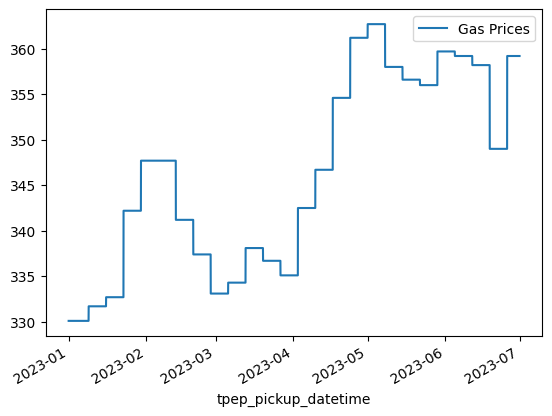

In [25]:
df.plot(x="tpep_pickup_datetime",y="Gas Prices", kind="line")


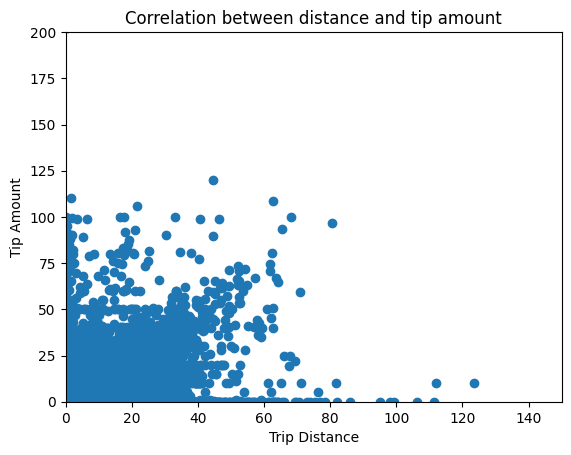

In [26]:
plt.title("Correlation between distance and tip amount")
plt.scatter(df['trip_distance'],df['tip_amount'])

plt.xlim(0.0, 150.0)
plt.xlabel("Trip Distance")

plt.ylim(0.0,200.0)
plt.ylabel("Tip Amount")
plt.show()
